In [0]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Callable, Iterable, List, Tuple
from tensorflow.keras.initializers import GlorotUniform
import numpy as np

In [2]:
!nvidia-smi

Tue Jun  9 06:58:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
class Dense(object):
    def __init__(self, in_feat: int, out_feat: int, activation: Callable = None, name: str = 'dense', initializer: Callable = GlorotUniform(seed=0))->None:
        # Weight parameters
        self.W = tf.Variable(initializer([in_feat, out_feat]), name=name + '_W')
        self.b = tf.Variable(tf.zeros([out_feat]), name=name + '_b')

        # params for weight updates
        self.params = [self.W, self.b]

        # layer attributes
        self.activation = activation

    def __call__(self, X: tf.Tensor) -> tf.Tensor:
        if callable(self.activation):
            return self.activation(tf.add(tf.matmul(X, self.W), self.b))

        else:
            return tf.add(tf.matmul(X, self.W), self.b)

    def forward(self, X: tf.Tensor) -> tf.Tensor:
        return self.__call__(X)

In [0]:
class Conv2D(object):
    def __init__(self, in_feat: int, out_feat: int, kernel_size: Tuple, strides: Tuple = (1, 1), activation: Callable = None, name: str = 'conv', padding: str = 'VALID', use_batch_norm: bool = False, initializer: Callable = GlorotUniform(seed=0)) -> None:
        # Weight parameters
        self.W = tf.Variable(initializer([kernel_size[0], kernel_size[1], in_feat, out_feat]), name=name + '_W')
        self.b = tf.Variable(tf.zeros([out_feat]), name=name + '_b')

        # params for weight updates
        self.params = [self.W, self.b]

        # layer attributes
        self.name = name
        self.stride = strides
        self.padding = padding
        self.activation = activation
        self.use_batch_norm = use_batch_norm

    def __call__(self, X: tf.Tensor) -> tf.Tensor:
        out = tf.nn.conv2d(X, self.W, strides=[1, self.stride[0], self.stride[1], 1], padding=self.padding)
        out = tf.nn.bias_add(out, self.b)

        if self.use_batch_norm:
            mean, variance = tf.nn.moments(out, axes=[0], keepdims=True)
            out = tf.nn.batch_normalization(out, mean=mean, variance=variance, offset=0.0, scale=1.0, variance_epsilon=1e-5)

        if callable(self.activation):
            out = self.activation(out)

        return out

    def forward(self, X: tf.Tensor) -> tf.Tensor:
        return self.__call__(X)

In [0]:
class CNN(tf.Module):
    def __init__(self):
        self.conv1 = Conv2D(1, 64, (3, 3), (1, 1), activation=tf.nn.selu, name='conv1')
        self.conv2 = Conv2D(64, 128, (3, 3), (1, 1), activation=tf.nn.selu, name='conv2')
        self.conv3 = Conv2D(128, 256, (3, 3), (1, 1), activation=tf.nn.selu, name='conv3')
        self.conv4 = Conv2D(256, 512, (3, 3), (1, 1), activation=tf.nn.selu, name='conv4')

        self.fc1 = Dense(131072, 128, activation=tf.nn.selu, name='fc1')
        self.fc2 = Dense(128, 256, activation=tf.nn.selu, name='fc2')
        self.fc3 = Dense(256, 10, activation=tf.nn.softmax, name='out')

        self.layers = [self.conv1, self.conv2, self.conv3, self.conv4, self.fc1, self.fc2, self.fc3]

        self.params = []

        for layer in self.layers:
            try:
                self.params.append([layer.W, layer.b])
            except:
                pass

        self.params = [j for i in self.params for j in i]

        self.loss = tf.keras.losses.categorical_crossentropy
        self.opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

    @tf.function
    def __call__(self, X: tf.Tensor) -> tf.Tensor:
        X = self.conv1(X)
        X = tf.nn.max_pool2d(X, 2, 1, 'VALID')
        X = self.conv2(X)
        X = tf.nn.max_pool2d(X, 2, 1, 'VALID')
        X = self.conv3(X)
        X = tf.nn.max_pool2d(X, 2, 1, 'VALID')
        X = self.conv4(X)
        X = tf.nn.max_pool2d(X, 2, 1, 'VALID')

        X = tf.reshape(X, [-1, X.shape[1] * X.shape[2] * X.shape[3]])

        X = self.fc1(X)
        X = tf.nn.dropout(X, rate=0.2)
        X = self.fc2(X)
        X = tf.nn.dropout(X, rate=0.2)
        X = self.fc3(X)

        return X

    def grad(self, y_hat, y_true):
        with tf.GradientTape() as g:
            y_hat = self.__call__(y_hat)
            error = self.cost(y_hat, y_true)

        return g.gradient(error, self.params), error, y_hat

    def cost(self, y_hat, y_true):
        return tf.reduce_mean(self.loss(y_true, y_hat))

    def backward(self, inputs, targets):
        grads, loss, y_hat = self.grad(inputs, targets)
        self.optimize(grads)
        return loss, y_hat

    def optimize(self, grads):
        self.opt.apply_gradients(zip(grads, self.params))

    def accuracy(self, y, yhat):
        correct = tf.equal(tf.argmax(y, 1), tf.argmax(yhat, 1))

        num = tf.reduce_sum(tf.cast(correct, dtype = tf.float32))
        den = tf.cast(y.shape[0], dtype = tf.float32)
        return num / den

    def evaluate(self, X_test, y_test, batch_size):
        num_examples = len(y_test)
        acc, loss = 0, 0

        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_test[offset:end], y_test[offset:end]

            y_hat = self.__call__(batch_x)
            loss = self.cost(y_hat, batch_y)

            acc = self.accuracy(batch_y, y_hat)

        print(f"Validation Accuracy: {acc:.4f} | Validation Loss: {loss:.4f}\n")

        return acc.numpy(), loss.numpy()

    def fit(self, X_train, y_train, epochs=30, batch_size=32, validation_data=()):
        num_examples = len(y_train)

        total_accuracy = []
        total_loss = []
        loss, acc = 0, 0
        val_loss, val_acc = 0, 0
        trn_err, trn_acy = [], []
        val_err, val_acy = [], []

        batch_x, batch_y = None, None

        X_test, y_test = validation_data

        for i in range(epochs):
            trn_loss = []
            trn_accy = []

            print("Epoch {}".format(i+1))

            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]

                loss, y_hat = self.backward(batch_x, batch_y)

                acc = self.accuracy(batch_y, y_hat)

                if(end==batch_size or end % 8192==0 or end==num_examples):
                    print(f"Batch [{end:5d}/{num_examples}] | Accuracy: {acc:.4f} | Loss: {loss:.4f}")

                trn_loss.append(loss)
                trn_accy.append(acc)

            trn_err = tf.reduce_mean(trn_loss).numpy()
            trn_acy = tf.reduce_mean(trn_accy).numpy()

            total_accuracy.append(trn_acy)
            total_loss.append(trn_err)

            val_acc, val_loss = self.evaluate(X_test, y_test, batch_size)

            val_acy.append(val_acc)
            val_err.append(val_loss)

        return {'accuracy': total_accuracy, 'loss': total_loss, 'val_accuracy': val_acy, 'val_loss': val_err}

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
X_train = tf.expand_dims(tf.cast(tf.convert_to_tensor(X_train/255.0), tf.float32), 3)
y_train = tf.keras.utils.to_categorical(y_train)
y_train = tf.cast(tf.convert_to_tensor(y_train), tf.float32)

In [0]:
X_test = tf.expand_dims(tf.cast(tf.convert_to_tensor(X_test/255.0), tf.float32), 3)
y_test = tf.keras.utils.to_categorical(y_test)
y_test = tf.cast(tf.convert_to_tensor(y_test), tf.float32)

In [0]:
model = CNN()

In [10]:
h = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1
Batch [   32/60000] | Accuracy: 0.0625 | Loss: 2.3701
Batch [ 8192/60000] | Accuracy: 0.9688 | Loss: 0.1509
Batch [16384/60000] | Accuracy: 0.9688 | Loss: 0.1427
Batch [24576/60000] | Accuracy: 0.9375 | Loss: 0.1180
Batch [32768/60000] | Accuracy: 0.9688 | Loss: 0.0532
Batch [40960/60000] | Accuracy: 0.9688 | Loss: 0.0853
Batch [49152/60000] | Accuracy: 0.9375 | Loss: 0.1868
Batch [57344/60000] | Accuracy: 0.9688 | Loss: 0.0521
Batch [60000/60000] | Accuracy: 1.0000 | Loss: 0.0349
Validation Accuracy: 0.9375 | Validation Loss: 0.1795

Epoch 2
Batch [   32/60000] | Accuracy: 0.9375 | Loss: 0.0884
Batch [ 8192/60000] | Accuracy: 1.0000 | Loss: 0.0228
Batch [16384/60000] | Accuracy: 0.9375 | Loss: 0.3233
Batch [24576/60000] | Accuracy: 1.0000 | Loss: 0.0417
Batch [32768/60000] | Accuracy: 0.9688 | Loss: 0.0530
Batch [40960/60000] | Accuracy: 0.9688 | Loss: 0.0702
Batch [49152/60000] | Accuracy: 0.9375 | Loss: 0.1395
Batch [57344/60000] | Accuracy: 1.0000 | Loss: 0.0266
Batch [6000

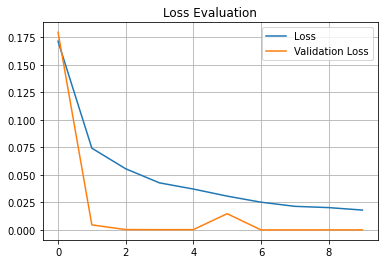

In [11]:
plt.plot(h['loss'], label='Loss')
plt.plot(h['val_loss'], label='Validation Loss')
plt.title('Loss Evaluation')
plt.legend()
plt.grid()
plt.show()

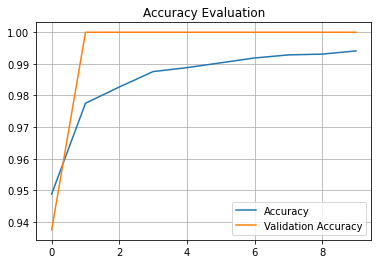

In [12]:
plt.plot(h['accuracy'], label='Accuracy')
plt.plot(h['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evaluation')
plt.legend()
plt.grid()
plt.show()

In [13]:
tf.saved_model.save(model, 'models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/assets


In [0]:
def download(url, name):
    image_path = tf.keras.utils.get_file(name, origin=url)
    return image_path

In [0]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_copy = img.copy()
    img = cv2.resize(img, (28, 28))
    img = img/255.0
    img = img.reshape(1, 28, 28, 1)
    return tf.cast(tf.convert_to_tensor(img), tf.float32), cv2.cvtColor(img_copy, cv2.COLOR_GRAY2RGB)

In [0]:
def predict(image_path):
  if image_path:
    image, original = preprocess_image(image_path)

    prediction = model(image)[0]

    print(f"Predicted Digit: {np.argmax(prediction.numpy())}")

    cv2.putText(original, 'Predicted Digit {}'.format(str(np.argmax(prediction.numpy()))), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2) 
    
    plt.axis('off')
    plt.imshow(original)

  else:
      print('User has not entered a valid path')

Enter image url: https://user-images.githubusercontent.com/379372/31909713-d9046856-b7ef-11e7-98fe-8a1e133c0010.png
Enter a name: 698hgki.png
8192/7907 [===============================] - 0s 0us/step
Predicted Digit: 4


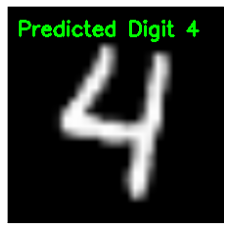

In [17]:
url = input('Enter image url: ')
name = input('Enter a name: ')
image_path = download(url, name)
predict(image_path)